In [2]:
import os, sys
sys.path.append(os.pardir)
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import logomaker
import torch
from src.datamodules.datamodule import BaseDataModule
from src.datamodules.components.dataset import BaseDataset
from src.models.model import BaseNet
from src.models.components.cnn import CNN
from src.models.components.rnn import RNN
from src.models.components.deepfam import DeepFam
from src.models.components.cnntrfm_pe import CNNTRFM_PE2
from src.models.components.cnnrnntrfm import CNNRNNTRFM
from captum.attr import IntegratedGradients

In [3]:
def get_ig(model, data):
    X, init_level, y = data
    X = X.unsqueeze(0)
    init_level = init_level.unsqueeze(0)
    ig = IntegratedGradients(model)
    attr_per_time = []
    for i in range(y.size(0)):
        attr, _ = ig.attribute(
            inputs=(X, init_level),
            baselines=(torch.zeros_like(X), torch.zeros_like(init_level)),
            target=i,
            n_steps=50
        )
        attr_per_time.append(attr)
    
    return torch.cat(attr_per_time, axis=0)

def get_ensemble_ig(models, data):
    attr_per_model = []
    for model in models:
        attr = get_ig(model, data)
        attr_per_model.append(attr.unsqueeze(0))
    
    return torch.cat(attr_per_model).mean(axis=0)

In [4]:
def draw_logo(attr_mats, titles):
    seq_mat = (attr_mats[0].sum(axis=0) != 0).type(torch.float)
    seq_df = pd.DataFrame(seq_mat, columns=["A", "U", "C", "G"])

    fig = plt.figure(figsize=(10, 1.3*(1+ len(attr_mats))))
    ax = fig.add_subplot(len(attr_mats) + 1, 1, 1)
    seq_logo = logomaker.Logo(seq_df, ax=ax)
    seq_logo.style_spines(spines=["right", "top"], visible=False)
    ax.set_ylabel("Score")
    ax.set_title("Sequence")
    ax.set_xticks([])

    for i, attr_mat in enumerate(attr_mats):
        score_df = pd.DataFrame(attr_mat.sum(axis=0), columns=["A", "U", "C", "G"])
        ax = fig.add_subplot(len(attr_mats) + 1, 1, i + 2)
        score_logo = logomaker.Logo(score_df, ax=ax)
        score_logo.style_spines(spines=["right", "top"], visible=False)
        ax.set_ylabel("IG score")
        ax.set_title(titles[i])
        ax.set_xticks([])

    fig.tight_layout()
    
    return fig

In [5]:
df = pd.read_csv("../data/designed.csv")
dataset = BaseDataset(df)

In [7]:
cnn_models = [BaseNet.load_from_checkpoint(f"../logs/experiments/runs/CNN/ckpts/seed{seed}.ckpt", net=CNN()) for seed in range(10)]
rnn_models = [BaseNet.load_from_checkpoint(f"../logs/experiments/runs/rnn_base/ckpts/seed{seed}.ckpt", net=RNN()) for seed in range(10)]
deepfam_models = [BaseNet.load_from_checkpoint(f"../logs/experiments/runs/deepfam_4kernels_channels256/ckpts/seed{seed}.ckpt", net=DeepFam(kernel_sizes=[6, 9, 12, 15], out_channels=256)) for seed in range(10)]
cnntrfm_models = [BaseNet.load_from_checkpoint(f"../logs/experiments/runs/cnntrfm-pe2-pool1/ckpts/seed{seed}.ckpt", net=CNNTRFM_PE2(pool_size=1)) for seed in range(10)]
cnnrnntrfm_models = [BaseNet.load_from_checkpoint(f"../logs/experiments/runs/cnnrnntrfm_base/ckpts/seed{seed}.ckpt", net=CNNRNNTRFM()) for seed in range(10)]

In [8]:
i = 48

cnn_attr_mat = get_ensemble_ig(cnn_models, dataset[i])
rnn_attr_mat = get_ensemble_ig(rnn_models, dataset[i])
deepfam_attr_mat = get_ensemble_ig(deepfam_models, dataset[i])
cnntrfm_attr_mat = get_ensemble_ig(cnntrfm_models, dataset[i])
cnnrnntrfm_attr_mat = get_ensemble_ig(cnnrnntrfm_models, dataset[i])

/data/project/danyoung/miniconda3/envs/dream/lib/python3.8/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


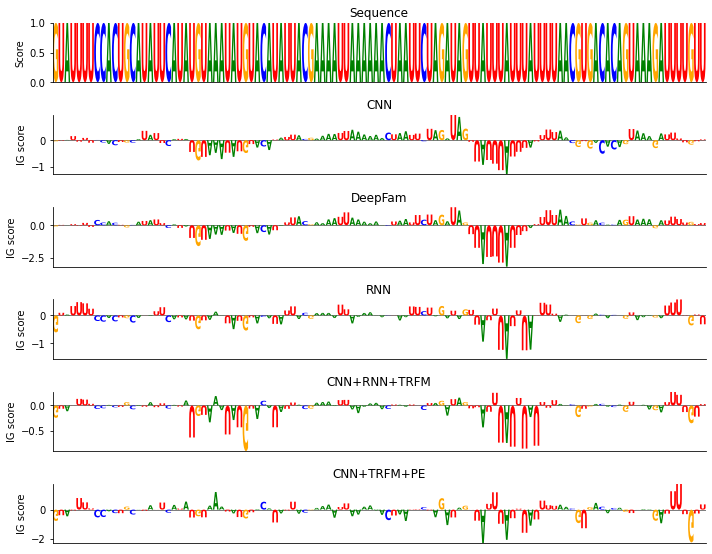

In [9]:
fig = draw_logo([cnn_attr_mat, deepfam_attr_mat, rnn_attr_mat, cnntrfm_attr_mat, cnnrnntrfm_attr_mat], titles=["CNN", "DeepFam", "RNN", "CNN+RNN+TRFM", "CNN+TRFM+PE"])
plt.savefig("../interpret.png", dpi=300, facecolor="w")

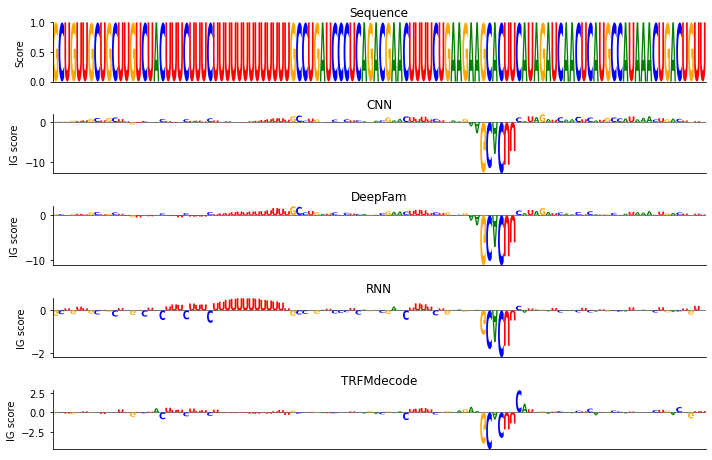

In [9]:
i = 30

cnn_attr_mat = get_ensemble_ig(cnn_models, dataset[i])
rnn_attr_mat = get_ensemble_ig(rnn_models, dataset[i])
deepfam_attr_mat = get_ensemble_ig(deepfam_models, dataset[i])
trfm_attr_mat = get_ensemble_ig(trfm_models, dataset[i])
draw_logo([cnn_attr_mat, deepfam_attr_mat, rnn_attr_mat, trfm_attr_mat], titles=["CNN", "DeepFam", "RNN", "TRFMdecode"])

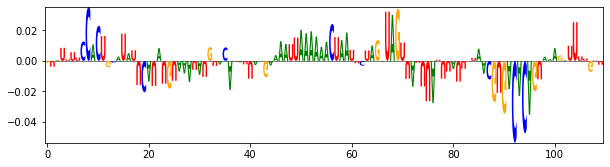

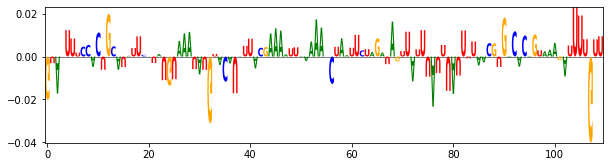

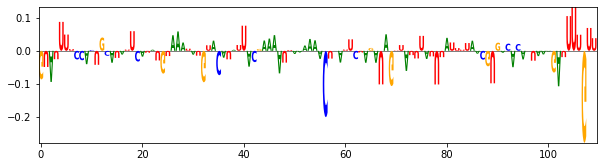

In [17]:
t = 

score_df = pd.DataFrame(cnn_attr_mat[t], columns=["A", "U", "C", "G"])
logomaker.Logo(score_df)

score_df = pd.DataFrame(cnntrfm_attr_mat[t], columns=["A", "U", "C", "G"])
logomaker.Logo(score_df)

score_df = pd.DataFrame(cnnrnntrfm_attr_mat[t], columns=["A", "U", "C", "G"])
logomaker.Logo(score_df)